In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fredapi import Fred
from config import my_api_key

## Load the dataset

In [3]:
def load_dataset(
    start_date: str = '1999-12-31',
    end_date: str = '2019-01-01') -> np.ndarray:
    '''
    Parameters
    ----------
    start_date: str, start date of the stock dataset, default = '1999-12-31'
    end_date: str, end date of the stock dataset, default = '2019-01-01'
    
    Returns
    -------
    np.ndarray
    '''
    data_raw = pd.read_csv('data_ml.csv', index_col=0)
    data_raw.reset_index(inplace=True)
    del data_raw['index']

    idx_date = data_raw.index[(data_raw['date'] > start_date) & (data_raw['date'] < end_date)].to_list()
    data_ml = data_raw.iloc[idx_date]
    
    return data_ml

In [4]:
data_ml = load_dataset()

## Swarmplot of correlations with the 1-month forward return

In [6]:
features_short = ['Div_Yld', 
                 'Eps',
                 'Mkt_Cap_12M_Usd',
                 'Mom_11M_Usd',
                 'Ocf',
                 'Pb',
                 'Vol1Y_Usd']
cols = features_short + ['R1M_Usd', 'date']

In [7]:
data_corr = data_ml[cols]
data_corr = data_corr.groupby('date').corr()[['R1M_Usd']].reset_index()
data_corr = data_corr.loc[data_corr[data_corr['level_1'].str[-7:] != 'R1M_Usd'].index]
data_corr.rename(columns={'level_1': 'Factors'}, inplace = True)

/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.9% of the points

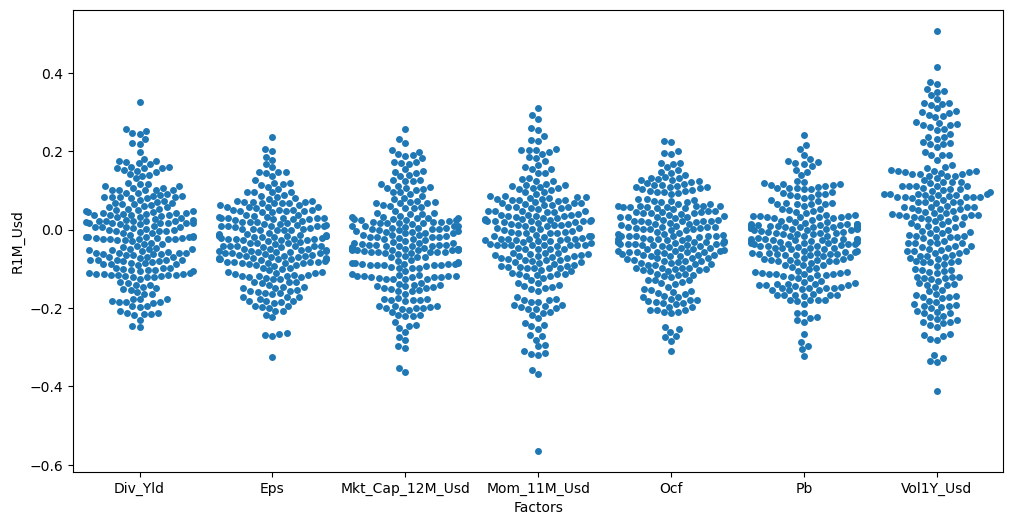

In [8]:
plt.figure(figsize=(12, 6))
sns.swarmplot(x='Factors', y='R1M_Usd', data=data_corr)
plt.show()

## Conditional average

In [10]:
unpivoted_data_ml = pd.melt(data_ml[['R1M_Usd', 'Mkt_Cap_12M_Usd', 'Vol1Y_Usd']],
                            id_vars = 'R1M_Usd')

In [11]:
unpivoted_data_ml.head()

,R1M_Usd,variable,value
0,0.089,Mkt_Cap_12M_Usd,0.24
1,0.039,Mkt_Cap_12M_Usd,0.24
2,-0.012,Mkt_Cap_12M_Usd,0.25
3,0.174,Mkt_Cap_12M_Usd,0.33
4,-0.106,Mkt_Cap_12M_Usd,0.30


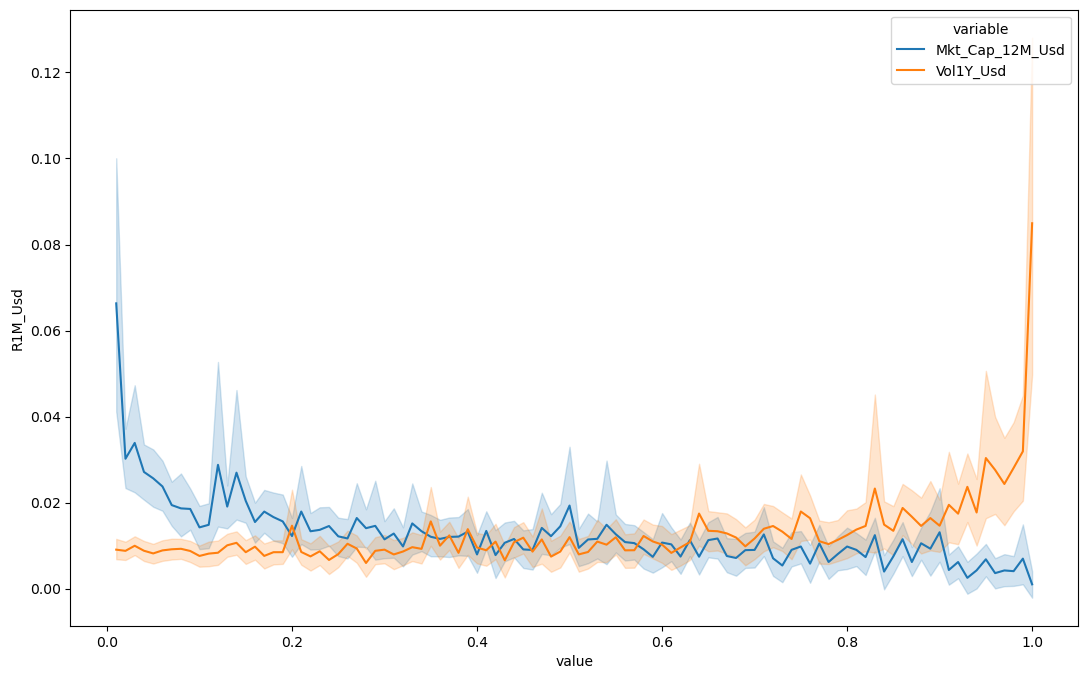

In [12]:
plt.figure(figsize=(13, 8))
sns.lineplot(data = unpivoted_data_ml,
             y = 'R1M_Usd',
             x = 'value',
             hue = 'variable')
plt.show()

## Autocorrelation

In [14]:
cols = ['stock_id'] + list(data_ml.iloc[:,3:95].columns)

In [15]:
data_hist_acf = pd.melt(data_ml[cols],
                        id_vars = 'stock_id').groupby(['stock_id', 'variable']).apply(lambda x: x['value'].autocorr(lag=1))

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/jz/_62zm7jn3y754w_n7gcp4v3m0000gn/T/ipykernel_20448/404374728.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  id_vars = 'stock_id').groupby(['stock_id', 'variable']).apply(lambda x: x['value'].autocorr(lag=1))


In [16]:
data_hist_acf.head()

stock_id  variable      
1         Advt_3M_Usd       0.958424
          Advt_6M_Usd       0.969035
          Asset_Turnover    0.825649
          Bb_Yld            0.606740
          Bv                0.998723
dtype: float64

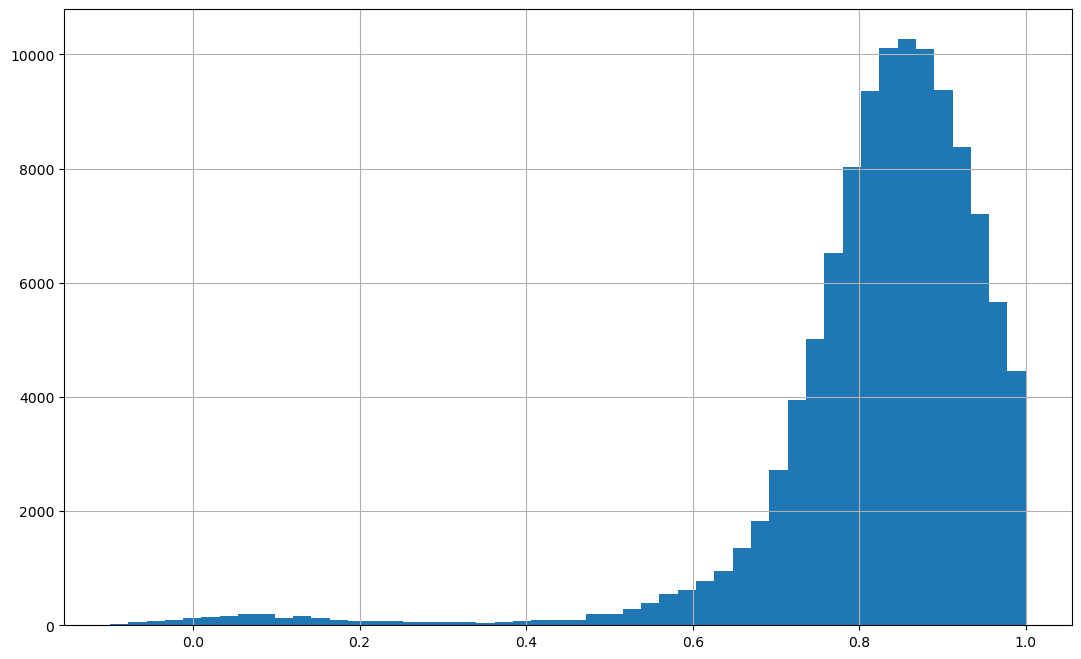

In [17]:
plt.figure(figsize=(13, 8))
data_hist_acf.hist(bins=50, range=[-0.1, 1])
plt.show()

## Impact of rescaling

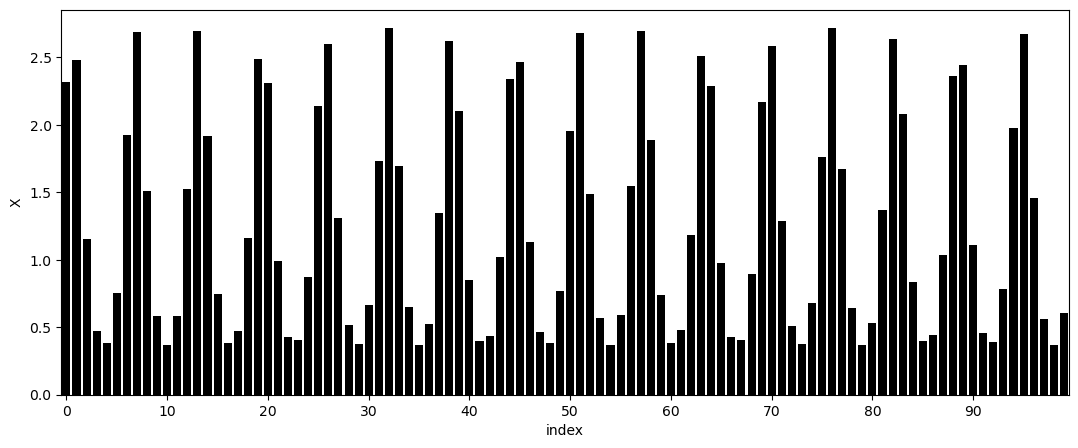

In [19]:
length = 100
x = np.exp(np.sin(np.linspace(1, length, length)))
data = pd.DataFrame(data = x, columns = ['X'])
data.reset_index(inplace = True)
plt.figure(figsize=(13, 5))
sns.barplot(y='X', data=data, x='index', color='black')
plt.xticks(data['index'][::10])
plt.show()

In [20]:
from statsmodels.distributions.empirical_distribution import ECDF

In [21]:
def norm_0_1(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

def norm_unif(x):
    return (ECDF(x)(x))

def norm_standard(x):
    return (x-np.mean(x))/np.std(x)

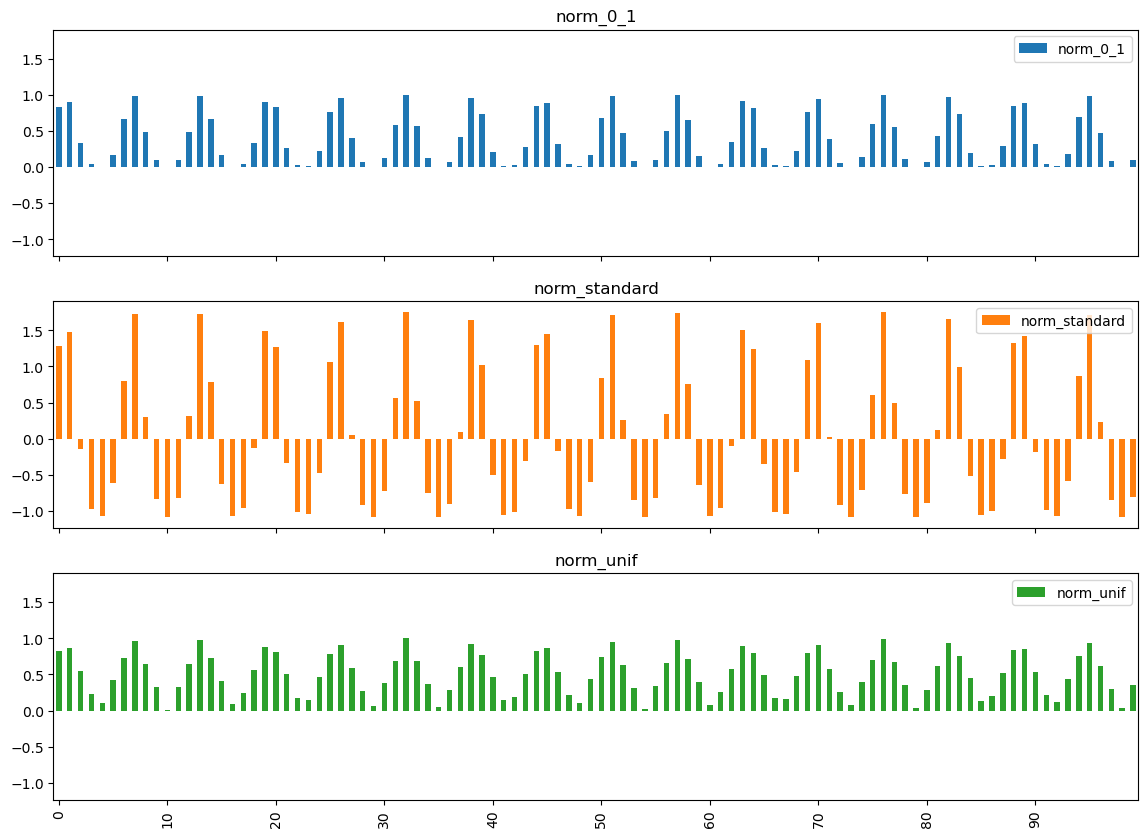

In [22]:
data_norm = pd.DataFrame.from_dict(dict(
    index = np.linspace(1, length, length),
    norm_0_1 = norm_0_1(x),
    norm_standard = norm_standard(x),
    norm_unif = norm_unif(x)))
data_norm.iloc[:,1:4].plot.bar(figsize=(14, 10), subplots=True, sharey=True, sharex=True)
plt.xticks(data['index'][::10])
plt.show()

## Macroeconomic Variables

### Multiply the features by an exogenous indicator $z_t$

In [25]:
fred = Fred(api_key=my_api_key)
# ICE BofA US Corporate Index Option-Adjusted Spread
dataseries = fred.get_series('BAMLC0A0CM')
dataseries.drop_duplicates()

1996-12-31    0.60
1997-01-01     NaN
1997-01-03    0.61
1997-01-09    0.62
1997-01-10    0.73
              ... 
2011-12-05    2.56
2020-03-19    3.51
2020-03-23    4.01
2020-03-25    3.54
2020-04-08    2.83
Length: 397, dtype: float64

In [26]:
dates_vector = pd.DataFrame(data_ml['date'].unique(), columns=['date'])

credit_spread = pd.DataFrame(dataseries).reset_index()
credit_spread.rename(columns={'index': 'date', 0: 'spread'}, inplace = True)
credit_spread['date'] = credit_spread['date'].astype('str')

credit_spread = pd.merge(dates_vector,
                         credit_spread,
                         how='left',
                         on='date')

credit_spread['spread'].fillna(method = 'ffill', inplace = True)

/var/folders/jz/_62zm7jn3y754w_n7gcp4v3m0000gn/T/ipykernel_20448/3404511120.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  credit_spread['spread'].fillna(method = 'ffill', inplace = True)
/var/folders/jz/_62zm7jn3y754w_n7gcp4v3m0000gn/T/ipykernel_20448/3404511120.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  credit_spread['spread'].fillna(method = 'ffill', inplace = True)


In [27]:
data_cond = pd.merge(data_ml,
                     credit_spread,
                     how='inner',
                     on='date')

In [28]:
for feature in features_short:
    data_cond[feature + '_cred_spread'] = data_cond[feature] * data_cond['spread']

In [29]:
data_cond[data_cond.columns[-len(features_short):]].describe()

,Div_Yld_cred_spread,Eps_cred_spread,Mkt_Cap_12M_Usd_cred_spread,Mom_11M_Usd_cred_spread,Ocf_cred_spread,Pb_cred_spread,Vol1Y_Usd_cred_spread
count,268336.000000,268336.000000,268336.000000,268336.000000,268336.000000,268336.000000,268336.000000
mean,0.841369,0.841726,0.840272,0.838885,0.839142,0.829854,0.838293
std,0.718133,0.717024,0.717665,0.717819,0.714742,0.707762,0.717229
min,0.008100,0.008100,0.008100,0.008100,0.008100,0.008100,0.008100
25%,0.358800,0.360800,0.357000,0.356200,0.358875,0.357500,0.356000
50%,0.710400,0.711550,0.708100,0.706200,0.709800,0.697200,0.705600
75%,1.125325,1.122400,1.125200,1.122400,1.120000,1.105100,1.122000
max,6.410000,6.410000,6.410000,6.410000,6.410000,6.410000,6.410000


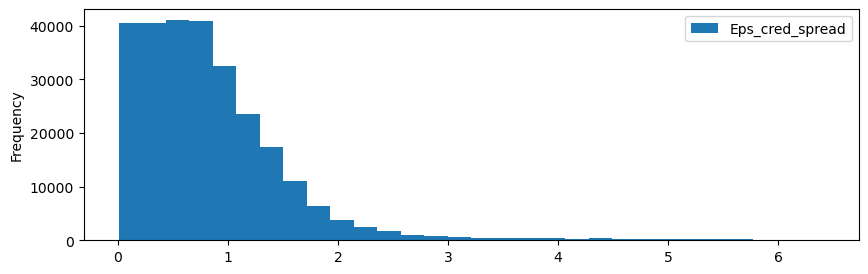

In [30]:
data_cond[['Eps_cred_spread']].plot.hist(bins=30, figsize=(10, 3))
plt.show()

After being multiplied by credit spread, the features are no longer uniform distibuted $\rightarrow$ the need to re-uniformize!

In [32]:
data_tmp = data_cond[['date', 'Div_Yld_cred_spread']].groupby(['date']).apply(lambda df: norm_0_1(df))

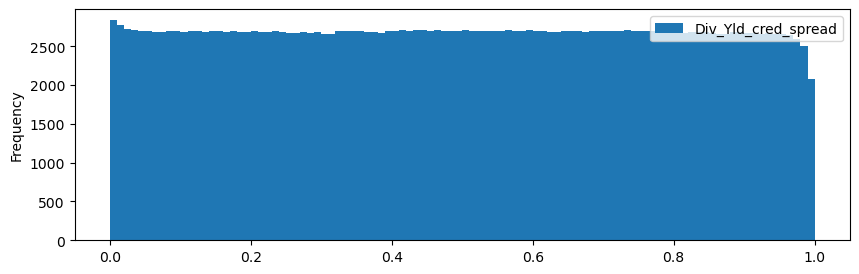

In [33]:
data_tmp[['Div_Yld_cred_spread']].plot.hist(bins=100, figsize=(10, 3))
plt.show()

In [34]:
data_tmp.reset_index(inplace = True)
data_tmp.rename(columns={'level_1': 'stock_id', 'Div_Yld_cred_spread': 'Div_Yld_cred_spread_uniformized'}, inplace = True)

In [35]:
final_df = pd.merge(data_cond,
                    data_tmp,
                    on=['date', 'stock_id'],)

In [36]:
final_df.describe()

,stock_id,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,Cash_Div_Cf,...,R12M_Usd,spread,Div_Yld_cred_spread,Eps_cred_spread,Mkt_Cap_12M_Usd_cred_spread,Mom_11M_Usd_cred_spread,Ocf_cred_spread,Pb_cred_spread,Vol1Y_Usd_cred_spread,Div_Yld_cred_spread_uniformized
count,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,...,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000
mean,603.889550,0.504494,0.504376,0.504936,0.502804,0.513237,0.503059,0.498445,0.500221,0.497332,...,0.137209,1.664231,0.850980,0.836191,0.839158,0.813088,0.838511,0.838529,0.847237,0.437690
std,349.665355,0.288303,0.287196,0.287821,0.288400,0.289896,0.290408,0.286942,0.289244,0.276337,...,0.473666,0.936846,0.770624,0.735148,0.724900,0.674212,0.713892,0.753375,0.748819,0.332776
min,1.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,-0.925000,0.810000,0.008900,0.009800,0.009100,0.009500,0.009200,0.009500,0.008900,0.000000
25%,304.000000,0.250000,0.250000,0.250000,0.260000,0.250000,0.250000,0.250000,0.250000,0.270000,...,-0.083000,1.120000,0.342400,0.357000,0.345100,0.355300,0.351900,0.342000,0.358900,0.151515
50%,604.000000,0.500000,0.500000,0.510000,0.500000,0.530000,0.510000,0.500000,0.500000,0.500000,...,0.090000,1.490000,0.694200,0.684000,0.709900,0.690300,0.699600,0.700600,0.693600,0.343434
75%,904.000000,0.760000,0.760000,0.760000,0.760000,0.760000,0.750000,0.740000,0.750000,0.720000,...,0.301000,1.820000,1.125000,1.120000,1.110000,1.096200,1.125000,1.097400,1.108800,0.696970
max,1212.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,6.083000,6.410000,6.060000,5.508400,5.858800,5.256900,5.938800,6.089500,5.897200,1.000000


## Interesting ideas to explore

1. A Machine Learning Framework for Stock Selection: https://arxiv.org/abs/1806.01743
2. Big Data and Machine Learning in Quantitative Investment
3. Machine Learning in Systematic Equity Allocation: A Model Comparison
4. Predictive Regressions
5. Training Trees on Tails with Applications to Portfolio Choice: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3403009
6. Empirical Asset Pricing via Machine Learning: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3159577